In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as TV

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
trans = TV.transforms.Compose([
    TV.transforms.ToTensor(),
    TV.transforms.Resize((128,128)),
    #TV.transforms.Normalize(mean=0.5, std=1),
])

In [3]:
dataset = TV.datasets.OxfordIIITPet('./datasets/', download=True, transform=trans)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting datasets/oxford-iiit-pet/images.tar.gz to datasets/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting datasets/oxford-iiit-pet/annotations.tar.gz to datasets/oxford-iiit-pet


In [4]:
BATCH_SIZE = 4

In [5]:
dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
#for img, label in dataloader_train:
#    print(img)
#    print(img.shape)
#    break

In [ ]:
'''
class ColoringAE(nn.Module):
  def __init__(self, in_nc, mid_nc, out_nc):
    super(ColoringAE, self).__init__()

    act = nn.GELU()
    pixelshuffle2x = nn.PixelShuffle(2)

    pad3 = nn.ReflectionPad2d(3)
    conv0 = nn.Conv2d(in_nc, mid_nc, kernel_size=7, stride=2, padding=0) # 128
    conv1 = nn.Conv2d(mid_nc, 2*mid_nc, kernel_size=3, stride=2, padding=1) # 64
    conv2 = nn.Conv2d(2*mid_nc, 2*mid_nc, kernel_size=3, stride=1, padding=1) # 64
    conv3 = nn.Conv2d(2*mid_nc, 4*mid_nc, kernel_size=3, stride=2, padding=1) # 32
    conv4 = nn.Conv2d(4*mid_nc, 8*mid_nc, kernel_size=3, stride=1, padding=1) # 32

    conv5 = nn.Conv2d(2*mid_nc, 4*mid_nc, kernel_size=3, stride=1, padding=1) # 64

    conv6 = nn.Conv2d(mid_nc, 2*mid_nc, kernel_size=3, stride=1, padding=1) # 128

    conv7 = nn.Conv2d(mid_nc//2, mid_nc//2, kernel_size=3, stride=1, padding=1) # 256

    conv8 = nn.Conv2d(mid_nc//2, out_nc, kernel_size=7, stride=1, padding=3) # 256

    model = [pad3, conv0, act, conv1, act, conv2, act, conv3, act, conv4, act,
             pixelshuffle2x, conv5, act, pixelshuffle2x, conv6, act,
             pixelshuffle2x, conv7, act, conv8]
    self.model = nn.Sequential(*model)
  def forward(self, x):
    return self.model(x)
  def print_num_parameters(self):
    num_params = sum(p.numel() for p in self.parameters())
    print(f'Arch params: {num_params}')
      
  def get_num_parameters(self):
    return sum(p.numel() for p in self.parameters())
'''

In [8]:
class Block(nn.Module):
  def __init__(self, in_nc, out_nc):
    super(Block, self).__init__()

    self.conv = nn.Conv2d(in_nc, out_nc, kernel_size=3, padding=1, stride=1)
    self.act = nn.GELU()

  def forward(self, x):
    out = self.conv(x)
    out = self.act(out)

    return out

class DownBlock(nn.Module):
  def __init__(self, in_nc, out_nc):
    super(DownBlock, self).__init__()

    self.conv = nn.Conv2d(in_nc, out_nc, kernel_size=3, padding=1, stride=2)
    self.act = nn.GELU()

  def forward(self, x):
    out = self.conv(x)
    out = self.act(out)

    return out

class UpBlock(nn.Module):
  def __init__(self, in_nc, out_nc):
    super(UpBlock, self).__init__()

    
    self.pixelshuffle2x = nn.PixelShuffle(2)
    self.conv = nn.Conv2d(in_nc, out_nc, kernel_size=3, padding=1, stride=1)
    self.act = nn.GELU()

  def forward(self, x):
    out = self.pixelshuffle2x(x)
    out = self.conv(out)
    out = self.act(out)

    return out

In [9]:
class ColoringAE(nn.Module):
  def __init__(self, in_nc, mid_nc, out_nc):
    super(ColoringAE, self).__init__()

    self.act = nn.GELU()
    #self.pixelshuffle2x = nn.PixelShuffle(2)

    self.pad3 = nn.ReflectionPad2d(3)
    self.conv0_0 = nn.Conv2d(in_nc, mid_nc, kernel_size=7, stride=2, padding=0) # 128
    
    self.down0 = DownBlock(mid_nc, 2*mid_nc) # 64
    self.block1 = Block(2*mid_nc, 2*mid_nc) # 64
    self.down1 = DownBlock(2*mid_nc, 4*mid_nc) # 32
    self.block2 = Block(4*mid_nc, 8*mid_nc) # 32
    self.down2 = DownBlock(8*mid_nc, 8*mid_nc) # 16
    self.block3 = Block(8*mid_nc, 16*mid_nc) # 16

    self.up3 = UpBlock(4*mid_nc, 8*mid_nc) # 32
    self.up2 = UpBlock(2*mid_nc, 4*mid_nc) # 64
    self.up1 = UpBlock(mid_nc, 2*mid_nc) # 128
    self.up0 = UpBlock(mid_nc//2, mid_nc//2) # 256

    self.conv_last = nn.Conv2d(mid_nc//2, out_nc, kernel_size=7, stride=1, padding=3) # 256

  def forward(self, x):
    mid = self.pad3(x)
    mid = self.conv0_0(mid)
    mid = self.act(mid)

    mid = self.down0(mid)
    mid = self.block1(mid)
    mid = self.down1(mid)
    mid = self.block2(mid)
    mid = self.down2(mid)
    mid = self.block3(mid)

    mid = self.up3(mid)
    mid = self.up2(mid)
    mid = self.up1(mid)
    mid = self.up0(mid)
    
    out = self.conv_last(mid)

    return out

  def print_num_parameters(self):
    num_params = sum(p.numel() for p in self.parameters())
    print(f'Arch params: {num_params}')
      
  def get_num_parameters(self):
    return sum(p.numel() for p in self.parameters())

In [10]:
class ColoringAEUnet(nn.Module):
  def __init__(self, in_nc, mid_nc, out_nc):
    super(ColoringAEUnet, self).__init__()

    self.act = nn.GELU()
    #self.pixelshuffle2x = nn.PixelShuffle(2)

    self.pad3 = nn.ReflectionPad2d(3)
    self.conv0_0 = nn.Conv2d(in_nc, mid_nc, kernel_size=7, stride=2, padding=0) # 128
    
    self.down0 = DownBlock(mid_nc, 2*mid_nc) # 64
    self.block1 = Block(2*mid_nc, 2*mid_nc) # 64
    self.down1 = DownBlock(2*mid_nc, 4*mid_nc) # 32
    self.block2 = Block(4*mid_nc, 8*mid_nc) # 32
    self.down2 = DownBlock(8*mid_nc, 8*mid_nc) # 16
    self.block3 = Block(8*mid_nc, 16*mid_nc) # 16

    self.up3 = UpBlock(4*mid_nc, 8*mid_nc) # 32
    self.conv1x1_2 = nn.Conv2d(8*mid_nc+8*mid_nc, 8*mid_nc, kernel_size=1)
    self.up2 = UpBlock(2*mid_nc, 4*mid_nc) # 64
    self.conv1x1_1 = nn.Conv2d(4*mid_nc+2*mid_nc, 4*mid_nc, kernel_size=1)
    self.up1 = UpBlock(mid_nc, 2*mid_nc) # 128
    self.conv1x1_0 = nn.Conv2d(2*mid_nc+mid_nc, 2*mid_nc, kernel_size=1)
    self.up0 = UpBlock(mid_nc//2, mid_nc//2) # 256

    self.conv_last = nn.Conv2d(mid_nc//2, out_nc, kernel_size=7, stride=1, padding=3) # 256

  def forward(self, x):
    mid = self.pad3(x)
    mid = self.conv0_0(mid)
    mid = self.act(mid)
    mid0 = mid

    mid = self.down0(mid)
    mid = self.block1(mid)
    mid1 = mid

    mid = self.down1(mid)
    mid = self.block2(mid)
    mid2 = mid

    mid = self.down2(mid)
    mid = self.block3(mid)

    #print(mid1.shape,mid2.shape, mid.shape)

    mid = self.up3(mid)
    mid = self.conv1x1_2(torch.cat((mid, mid2), axis=1))
    mid = self.up2(mid)
    #print(mid.shape, mid1.shape)
    mid = self.conv1x1_1(torch.cat((mid, mid1), axis=1))
    mid = self.up1(mid)
    mid = self.conv1x1_0(torch.cat((mid, mid0), axis=1))
    mid = self.up0(mid)
    
    out = self.conv_last(mid)

    return out

  def print_num_parameters(self):
    num_params = sum(p.numel() for p in self.parameters())
    print(f'Arch params: {num_params}')
      
  def get_num_parameters(self):
    return sum(p.numel() for p in self.parameters())

In [11]:
model = ColoringAEUnet(1, 48, 3)

In [12]:
model.print_num_parameters()

Arch params: 6184515


In [13]:
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=4.0e-4, betas=(0.9, 0.999))
loss_func_l1 = torch.nn.L1Loss()
loss_func_l2 = torch.nn.MSELoss()

In [14]:
EPOCHS = 100

iters = 0
loss_val = 0.0
total_loss = 0

for epoch in range(EPOCHS):
  total_loss = 0
  pbar = tqdm(dataloader_train)
  for img_A, _ in pbar:
    img_A = img_A.cuda()
    img_Agray = (img_A[:,0:1] + img_A[:,1:2] + img_A[:,2:3])/3.0

    img_B = model(img_Agray)
    img_Bgray = (img_B[:,0:1] + img_B[:,1:2] + img_B[:,2:3])/3.0

    loss_color = loss_func_l1(img_B, img_A)
    loss_value = loss_func_l1(img_Bgray, img_Agray)
    
    loss = 0.9*loss_color + 0.1*loss_value

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss += loss
    loss_val = 0.9*loss_val + 0.1*loss.item()
    pbar.set_description(f'loss: {round(loss_val, 6)}, iters: {iters}')
    
    iters += 1
  
  for g in optimizer.param_groups:
    g['lr'] /= 1.1 if g['lr'] >= 5e-5 else 1.04
    lr = g['lr']
  total_loss_val = total_loss.item()/len(dataloader_train)
  print(f'Epoch: {epoch}\tloss: {round(total_loss_val, 6)}\tSet lr to: {round(lr, 7)}')

loss: 0.062337, iters: 919: 100%|██████████| 920/920 [00:44<00:00, 20.82it/s]


Epoch: 0	loss: 0.074205	Set lr to: 0.0003636


loss: 0.050134, iters: 1839: 100%|██████████| 920/920 [00:42<00:00, 21.44it/s]


Epoch: 1	loss: 0.053611	Set lr to: 0.0003306


loss: 0.047393, iters: 2759: 100%|██████████| 920/920 [00:43<00:00, 21.23it/s]


Epoch: 2	loss: 0.048474	Set lr to: 0.0003005


loss: 0.043969, iters: 3679: 100%|██████████| 920/920 [00:42<00:00, 21.71it/s]


Epoch: 3	loss: 0.044924	Set lr to: 0.0002732


loss: 0.042268, iters: 4599: 100%|██████████| 920/920 [00:41<00:00, 22.04it/s]


Epoch: 4	loss: 0.042749	Set lr to: 0.0002484


loss: 0.041032, iters: 5519: 100%|██████████| 920/920 [00:42<00:00, 21.65it/s]


Epoch: 5	loss: 0.041542	Set lr to: 0.0002258


loss: 0.039808, iters: 6439: 100%|██████████| 920/920 [00:42<00:00, 21.69it/s]


Epoch: 6	loss: 0.041002	Set lr to: 0.0002053


loss: 0.039123, iters: 7359: 100%|██████████| 920/920 [00:42<00:00, 21.65it/s]


Epoch: 7	loss: 0.040735	Set lr to: 0.0001866


loss: 0.035546, iters: 8279: 100%|██████████| 920/920 [00:42<00:00, 21.81it/s]


Epoch: 8	loss: 0.040529	Set lr to: 0.0001696


loss: 0.039655, iters: 9199: 100%|██████████| 920/920 [00:43<00:00, 21.31it/s]


Epoch: 9	loss: 0.040448	Set lr to: 0.0001542


loss: 0.038498, iters: 10119: 100%|██████████| 920/920 [00:42<00:00, 21.89it/s]


Epoch: 10	loss: 0.04029	Set lr to: 0.0001402


loss: 0.038672, iters: 11039: 100%|██████████| 920/920 [00:41<00:00, 22.15it/s]


Epoch: 11	loss: 0.0402	Set lr to: 0.0001275


loss: 0.035644, iters: 11959: 100%|██████████| 920/920 [00:41<00:00, 21.92it/s]


Epoch: 12	loss: 0.040087	Set lr to: 0.0001159


loss: 0.038461, iters: 12879: 100%|██████████| 920/920 [00:44<00:00, 20.75it/s]


Epoch: 13	loss: 0.039946	Set lr to: 0.0001053


loss: 0.038487, iters: 13799: 100%|██████████| 920/920 [00:43<00:00, 20.93it/s]


Epoch: 14	loss: 0.039901	Set lr to: 9.58e-05


loss: 0.037328, iters: 14719: 100%|██████████| 920/920 [00:43<00:00, 21.07it/s]


Epoch: 15	loss: 0.039754	Set lr to: 8.71e-05


loss: 0.039395, iters: 15639: 100%|██████████| 920/920 [00:43<00:00, 20.96it/s]


Epoch: 16	loss: 0.039631	Set lr to: 7.91e-05


loss: 0.037974, iters: 16559: 100%|██████████| 920/920 [00:44<00:00, 20.80it/s]


Epoch: 17	loss: 0.039526	Set lr to: 7.19e-05


loss: 0.037762, iters: 17479: 100%|██████████| 920/920 [00:44<00:00, 20.56it/s]


Epoch: 18	loss: 0.039368	Set lr to: 6.54e-05


loss: 0.038743, iters: 18399: 100%|██████████| 920/920 [00:44<00:00, 20.66it/s]


Epoch: 19	loss: 0.039242	Set lr to: 5.95e-05


loss: 0.036125, iters: 19319: 100%|██████████| 920/920 [00:44<00:00, 20.60it/s]


Epoch: 20	loss: 0.039052	Set lr to: 5.41e-05


loss: 0.037503, iters: 20239: 100%|██████████| 920/920 [00:44<00:00, 20.49it/s]


Epoch: 21	loss: 0.038806	Set lr to: 4.91e-05


loss: 0.036512, iters: 21159: 100%|██████████| 920/920 [00:43<00:00, 20.92it/s]


Epoch: 22	loss: 0.038529	Set lr to: 4.72e-05


loss: 0.03726, iters: 22079: 100%|██████████| 920/920 [00:43<00:00, 20.98it/s]


Epoch: 23	loss: 0.038228	Set lr to: 4.54e-05


loss: 0.036348, iters: 22999: 100%|██████████| 920/920 [00:43<00:00, 21.21it/s]


Epoch: 24	loss: 0.03784	Set lr to: 4.37e-05


loss: 0.03852, iters: 23919: 100%|██████████| 920/920 [00:43<00:00, 20.99it/s]


Epoch: 25	loss: 0.037394	Set lr to: 4.2e-05


loss: 0.039657, iters: 24839: 100%|██████████| 920/920 [00:43<00:00, 20.91it/s]


Epoch: 26	loss: 0.036869	Set lr to: 4.04e-05


loss: 0.036884, iters: 25759: 100%|██████████| 920/920 [00:45<00:00, 20.35it/s]


Epoch: 27	loss: 0.036233	Set lr to: 3.88e-05


loss: 0.034135, iters: 26679: 100%|██████████| 920/920 [00:44<00:00, 20.48it/s]


Epoch: 28	loss: 0.035614	Set lr to: 3.73e-05


loss: 0.035109, iters: 27599: 100%|██████████| 920/920 [00:43<00:00, 21.09it/s]


Epoch: 29	loss: 0.034932	Set lr to: 3.59e-05


loss: 0.032882, iters: 28519: 100%|██████████| 920/920 [00:46<00:00, 19.58it/s]


Epoch: 30	loss: 0.034259	Set lr to: 3.45e-05


loss: 0.029879, iters: 29439: 100%|██████████| 920/920 [00:45<00:00, 20.41it/s]


Epoch: 31	loss: 0.03354	Set lr to: 3.32e-05


loss: 0.030391, iters: 30359: 100%|██████████| 920/920 [00:45<00:00, 20.42it/s]


Epoch: 32	loss: 0.032877	Set lr to: 3.19e-05


loss: 0.031991, iters: 31279: 100%|██████████| 920/920 [00:47<00:00, 19.39it/s]


Epoch: 33	loss: 0.032177	Set lr to: 3.07e-05


loss: 0.033685, iters: 32199: 100%|██████████| 920/920 [00:44<00:00, 20.60it/s]


Epoch: 34	loss: 0.03153	Set lr to: 2.95e-05


loss: 0.030021, iters: 33119: 100%|██████████| 920/920 [00:46<00:00, 19.59it/s]


Epoch: 35	loss: 0.030904	Set lr to: 2.84e-05


loss: 0.027727, iters: 34039: 100%|██████████| 920/920 [00:44<00:00, 20.70it/s]


Epoch: 36	loss: 0.030298	Set lr to: 2.73e-05


loss: 0.033907, iters: 34959: 100%|██████████| 920/920 [00:45<00:00, 20.12it/s]


Epoch: 37	loss: 0.029731	Set lr to: 2.62e-05


loss: 0.030495, iters: 35879: 100%|██████████| 920/920 [00:45<00:00, 20.16it/s]


Epoch: 38	loss: 0.029207	Set lr to: 2.52e-05


loss: 0.030998, iters: 36799: 100%|██████████| 920/920 [00:46<00:00, 19.96it/s]


Epoch: 39	loss: 0.028712	Set lr to: 2.43e-05


loss: 0.027136, iters: 37719: 100%|██████████| 920/920 [00:46<00:00, 19.97it/s]


Epoch: 40	loss: 0.028218	Set lr to: 2.33e-05


loss: 0.028725, iters: 38639: 100%|██████████| 920/920 [00:45<00:00, 20.04it/s]


Epoch: 41	loss: 0.027743	Set lr to: 2.24e-05


loss: 0.029364, iters: 39559: 100%|██████████| 920/920 [00:46<00:00, 19.80it/s]


Epoch: 42	loss: 0.027322	Set lr to: 2.16e-05


loss: 0.030052, iters: 40479: 100%|██████████| 920/920 [00:45<00:00, 20.44it/s]


Epoch: 43	loss: 0.026925	Set lr to: 2.07e-05


loss: 0.026803, iters: 41399: 100%|██████████| 920/920 [00:45<00:00, 20.16it/s]


Epoch: 44	loss: 0.026538	Set lr to: 1.99e-05


loss: 0.026433, iters: 42319: 100%|██████████| 920/920 [00:45<00:00, 20.27it/s]


Epoch: 45	loss: 0.026167	Set lr to: 1.92e-05


loss: 0.021913, iters: 43239: 100%|██████████| 920/920 [00:46<00:00, 19.60it/s]


Epoch: 46	loss: 0.025803	Set lr to: 1.84e-05


loss: 0.024528, iters: 44159: 100%|██████████| 920/920 [00:48<00:00, 19.10it/s]


Epoch: 47	loss: 0.025484	Set lr to: 1.77e-05


loss: 0.024294, iters: 45079: 100%|██████████| 920/920 [00:48<00:00, 18.96it/s]


Epoch: 48	loss: 0.025163	Set lr to: 1.7e-05


loss: 0.023667, iters: 45999: 100%|██████████| 920/920 [00:46<00:00, 19.71it/s]


Epoch: 49	loss: 0.024868	Set lr to: 1.64e-05


loss: 0.022848, iters: 46919: 100%|██████████| 920/920 [00:44<00:00, 20.63it/s]


Epoch: 50	loss: 0.024596	Set lr to: 1.58e-05


loss: 0.022852, iters: 47839: 100%|██████████| 920/920 [00:44<00:00, 20.87it/s]


Epoch: 51	loss: 0.024321	Set lr to: 1.52e-05


loss: 0.02619, iters: 47915:   8%|▊         | 75/920 [00:03<00:39, 21.26it/s] 


KeyboardInterrupt: ignored

In [15]:
def get_normed(X):
    return (X-X.min())/(X.max()-X.min())

In [16]:
img_gray = img_Agray
img_gray = img_gray.detach().cpu().numpy()

img = img_A
img = img.detach().cpu().numpy()

img_res = img_B
img_res = img_res.detach().cpu().numpy()
img_res = get_normed(img_res)

In [17]:
img.shape

(4, 3, 128, 128)

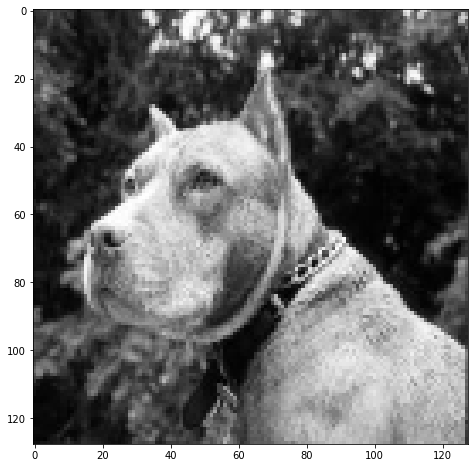

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(img_gray[0][0], cmap='gray')

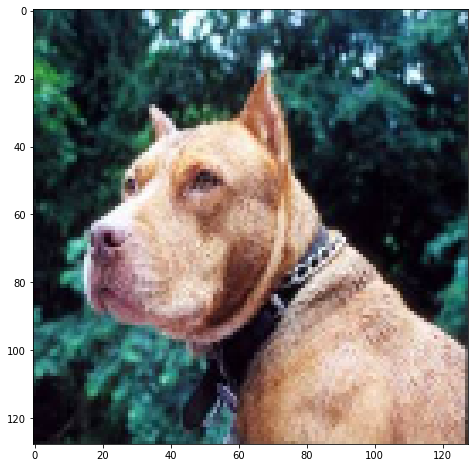

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(img[0].transpose((1,2,0)))

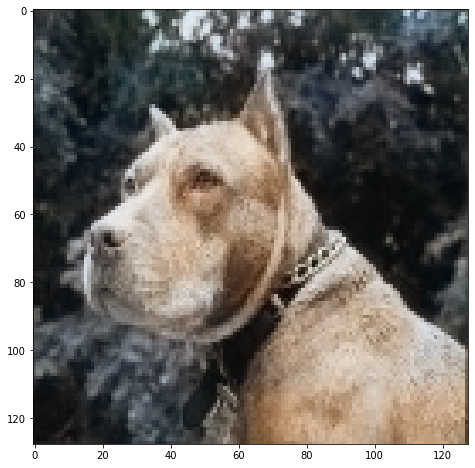

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(img_res[0].transpose((1,2,0)))

In [21]:
torch.save(model.state_dict, './coloring_ae_unet.pth')

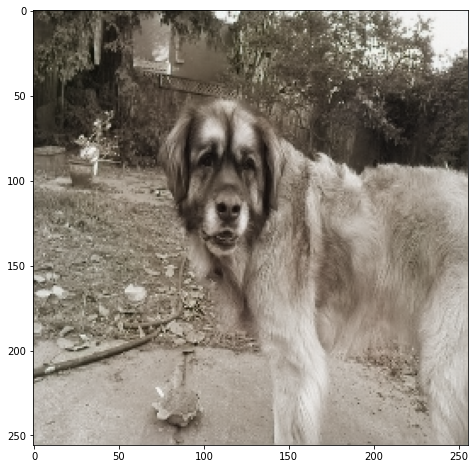

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(img_res[0].transpose((1,2,0)))